In [1]:
import json
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import torch
import torch.nn as nn
from PIL import Image
from tqdm import tqdm
from transformers import AdamW, ViTModel, BertModel, BertTokenizer, ViTFeatureExtractor
from torch.nn.functional import cosine_similarity

/home/ayu/Downloads/archive/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

# Load Vision Transformer (ViT) model and feature extractor
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')
vit_model = ViTModel.from_pretrained('google/vit-base-patch16-224')

/home/ayu/Downloads/archive/.venv/lib/python3.12/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
# Custom model for BERT embeddings (Text Embeddings)
class BertForImageRetrieval(nn.Module):
    def __init__(self, bert_model):
        super(BertForImageRetrieval, self).__init__()
        self.bert = bert_model
        self.fc = nn.Linear(768, 512)  # Map to 512-dim embedding

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs[1]  # Pooled [CLS] token output
        return self.fc(pooled_output)

# Custom model for ViT embeddings (Image Embeddings)
class ViTForImageRetrieval(nn.Module):
    def __init__(self, vit_model):
        super(ViTForImageRetrieval, self).__init__()
        self.vit = vit_model
        self.fc = nn.Linear(768, 512)  # Map to 512-dim embedding

    def forward(self, pixel_values):
        outputs = self.vit(pixel_values=pixel_values)
        return self.fc(outputs.pooler_output)

# Initialize the custom BERT and ViT models
bert_retrieval_model = BertForImageRetrieval(bert_model)
vit_retrieval_model = ViTForImageRetrieval(vit_model)

In [4]:
def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image = image.resize((224, 224))
    # resizes the image to 224x224
    image = feature_extractor(images=image, return_tensors="pt")
    return image['pixel_values']

# Extract image embeddings using the fine-tuned ViT model
def get_image_embedding(image_path):
    image = preprocess_image(image_path)
    with torch.no_grad():
        outputs = vit_retrieval_model(image)
    return outputs

# Extract text embeddings using the fine-tuned BERT model
def get_text_embedding(caption):
    inputs = tokenizer(caption, return_tensors='pt', truncation=True, padding=True)
    with torch.no_grad():
        text_embedding = bert_retrieval_model(inputs.input_ids, inputs.attention_mask)
    return text_embedding

In [5]:
def cross_entropy_loss(comb_emb, image_embeddings, label):
    # Compute cosine similarity (between -1 and 1)
    similarities = cosine_similarity(comb_emb, image_embeddings)

    logits = similarities.unsqueeze(0)  # Add batch dimension
    
    logits = torch.cat([1 - logits, logits], dim=1)  # Two classes: non-match (0) and match (1)

    # Create target label
    labels = torch.tensor([label], dtype=torch.long)

    # Define loss function
    loss_fn = nn.CrossEntropyLoss()
    return loss_fn(logits, labels)

In [9]:
optimizer = torch.optim.AdamW(
    list(bert_retrieval_model.parameters()) + list(vit_retrieval_model.parameters()), lr=1e-5
)

In [13]:
# Function to randomly select a non-matching target image
def get_random_image(image_dir, current_target_id):
    image_files = [f for f in os.listdir('fashionIQ_dataset/image_splits') if f.endswith('train.json')]
    image_set = []
    for file in image_files:
        with open(os.path.join('fashionIQ_dataset/image_splits', file), 'r') as f:
            image_set += json.load(f)

    if current_target_id in image_set:
        image_set.remove(current_target_id)
    random_item = random.choice(image_set)
    return os.path.join(image_dir, random_item + '.jpg')

# Function to compute Euclidean distance between two embeddings
def euclidean_distance(embedding1, embedding2):
    return torch.sqrt(torch.sum((embedding1 - embedding2) ** 2))

In [ ]:
# Training loop
bert_retrieval_model.train()
vit_retrieval_model.train()

caption_dir = 'fashionIQ_dataset/captions'
image_dir = 'fashionIQ_dataset/images'

losses = []
for filename in [f for f in os.listdir(caption_dir) if f.endswith('.train.json')]:
    print(filename)
    caption_file = os.path.join(caption_dir, filename)
    with open(caption_file, 'r') as f:
        captions_data = json.load(f)

    for item in tqdm(captions_data):
        target_image_id = item['target']
        candidate_image_id = item['candidate']
        captions = item['captions'][0] +  " and " + item['captions'][1]

        # Paths for target and candidate images
        target_image_path = os.path.join(image_dir, target_image_id + ".jpg")
        candidate_image_path = os.path.join(image_dir, candidate_image_id + ".jpg")

        try:
            # Get image embeddings for target and candidate
            target_image_emb = get_image_embedding(target_image_path).requires_grad_()
            candidate_image_emb = get_image_embedding(candidate_image_path).requires_grad_()

            # Positive Pair (Matching candidate image and caption)
            text_emb = get_text_embedding(captions).requires_grad_()
            comb_emb = (text_emb.clone() + candidate_image_emb.clone())/2
            positive_loss = cross_entropy_loss(comb_emb, target_image_emb, label=1)    

            # get a negative taget image embedding
            negative_image_emb =  get_image_embedding(get_random_image(image_dir, target_image_id))
            negative_loss = cross_entropy_loss(comb_emb, negative_image_emb, label=0)

            # Total loss (sum of positive and negative losses)
            total_loss = positive_loss + negative_loss
            losses.append(total_loss.item())

            # Backpropagation
            total_loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        except Exception as e:
            print(f"Error processing image {candidate_image_id}: {e}")

cap.toptee.train.json


100%|██████████| 6027/6027 [33:31<00:00,  3.00it/s] 


cap.dress.train.json


100%|██████████| 5985/5985 [35:03<00:00,  2.84it/s]  


cap.shirt.train.json


100%|██████████| 5988/5988 [36:03<00:00,  2.77it/s]  


In [67]:
# save the model binaries
torch.save(bert_retrieval_model.state_dict(), 'bert_retrieval_model.pth')
torch.save(vit_retrieval_model.state_dict(), 'vit_retrieval_model.pth')

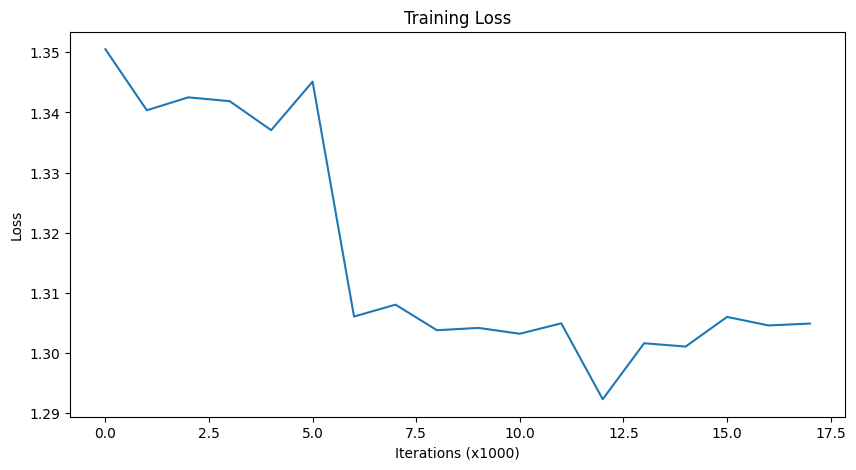

In [73]:
# learning curve using losses
loss_sample = [np.mean(losses[i:i+1000]) for i in range(0, len(losses), 1000)]
plt.figure(figsize=(10, 5))
plt.plot(loss_sample)
plt.xlabel('Iterations (x1000)')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [ ]:
# if os.path.exists('image_embeddings.pth'):
#     map_image_emb = torch.load('image_embeddings.pth')
# else:
#     image_files = os.listdir(image_dir)
#     map_image_emb = {}

#     # dictionary of image and its embeddings
#     for image in tqdm(image_files):
#         map_image_emb[image.replace('.jpg', '')] = get_image_embedding(os.path.join(image_dir, image))

#     # Save the image embeddings
#     torch.save(map_image_emb, 'image_embeddings.pth')

# print(f"Total images: {len(map_image_emb.keys())}")

/tmp/ipykernel_61282/3245621761.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  map_image_emb = torch.load('image_embeddings.pth')


Total images: 74381


In [6]:
# load the model binaries
bert_retrieval_model.load_state_dict(torch.load('bert_retrieval_model.pth'))
vit_retrieval_model.load_state_dict(torch.load('vit_retrieval_model.pth'))

# Load the image embeddings
map_image_emb = torch.load('image_embeddings.pth')

/tmp/ipykernel_100181/3635500718.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  bert_retrieval_model.load_state_dict(torch.load('bert_retrieval_model.pth'))
/tmp/ipyker

In [12]:
# Validation loop
bert_retrieval_model.eval()
vit_retrieval_model.eval()

caption_dir = 'fashionIQ_dataset/captions'
image_dir = 'fashionIQ_dataset/images'
image_splits_dir = 'fashionIQ_dataset/image_splits'

retrieved_images_5 = []
retrieved_images_10 = []
retrieved_images_20 = []
retrieved_images_30 = []
retrieved_images_50 = []
target_images = []

# Function to compute Euclidean distance between two embeddings
def euclidean_distance(embedding1, embedding2):
    return torch.sqrt(torch.sum((embedding1 - embedding2) ** 2))

for filename in [f for f in os.listdir(caption_dir) if f.endswith('.val.json')]:
    print(filename)
    caption_file = os.path.join(caption_dir, filename)
    with open(caption_file, 'r') as f:
        captions_data = json.load(f)

    image_file = os.path.join(image_splits_dir, filename.replace('cap', 'split'))
    with open(image_file, 'r') as f:
        image_data = json.load(f)

    for item in tqdm(captions_data):
        candidate = item['candidate']
        caption = item['captions'][0] + " and " + item['captions'][1]

        query_image_emb = map_image_emb[candidate]
        query_text_emb = get_text_embedding(caption)
        combined_query_emb = (query_image_emb + query_text_emb) / 2.0 

        image_distances =[]
        for image in image_data:
            try:
                image_emb = map_image_emb[image]
                distance = euclidean_distance(combined_query_emb, image_emb)
                
                # Append tuple (image id, distance) to list
                image_distances.append((image, distance.item()))
            except Exception as e:
                print(f"Error processing image {image}: {e}")
        
        image_distances.sort(key=lambda x: x[1], reverse=False)
        
        retrieved_images_5.append(image_distances[:5])
        retrieved_images_10.append(image_distances[:10])
        retrieved_images_20.append(image_distances[:20])
        retrieved_images_30.append(image_distances[:30])
        retrieved_images_50.append(image_distances[:50])

        target_images.append(item['target'])

# print(f"Total candidates: {len(retrieved_images)}")
print(f"Total targets: {len(target_images)}")

cap.toptee.val.json


100%|██████████| 1961/1961 [03:41<00:00,  8.84it/s]


cap.shirt.val.json


100%|██████████| 2038/2038 [04:02<00:00,  8.40it/s]


cap.dress.val.json


100%|██████████| 2017/2017 [03:08<00:00, 10.71it/s]

Total targets: 6016


In [13]:
# Function to calculate recall for different top-k values
def calculate_recall(retrieved_images, target_images):    
    total_ret_img = []
    for ret_img in retrieved_images:
        x = [img for img, _ in ret_img]
        for i in x:
            total_ret_img.append(i)
        
    tp = 0.0
    fn = 0.0
    for i in range(len(retrieved_images)):
        batch_ret_img = [img for img , _ in retrieved_images[i]]
        batch_tgt_img = target_images[i]

        if batch_tgt_img in batch_ret_img:
            tp += 1
        elif (batch_tgt_img not in batch_ret_img) and (batch_tgt_img in total_ret_img):
            fn += 1

    if((tp + fn)!=0):
        return tp/(tp+fn)
    else:
        return 0

# Function to calculate precision for different top-k values
def calculate_precision(retrieved_images, target_images):
    tp = 0.0
    fp = 0.0
    for i in range(len(retrieved_images)):
        batch_ret_img = [img for img , _ in retrieved_images[i]]
        batch_tgt_img = target_images[i]

        if batch_tgt_img in batch_ret_img:
            tp += 1
        else:
            fp += 1
        
    if((tp + fp)!=0):
        return tp/(tp+fp)
    else:
        return 0

In [14]:
calculate_precision(retrieved_images_50, target_images)

0.07430186170212766

In [15]:
recall = {}

recall["5"] = calculate_recall(retrieved_images_5, target_images)
recall["10"] = calculate_recall(retrieved_images_10, target_images)
recall["20"] = calculate_recall(retrieved_images_20, target_images)
recall["30"] = calculate_recall(retrieved_images_30, target_images)
recall["50"] = calculate_recall(retrieved_images_50, target_images)

precision = {}

precision["5"] = calculate_precision(retrieved_images_5, target_images)
precision["10"] = calculate_precision(retrieved_images_10, target_images)
precision["20"] = calculate_precision(retrieved_images_20, target_images)
precision["30"] = calculate_precision(retrieved_images_30, target_images)
precision["50"] = calculate_precision(retrieved_images_50, target_images)

print(recall, precision)

{'5': 0.030552694816340542, '10': 0.04341575618171363, '20': 0.06344928956393925, '30': 0.07313769751693003, '50': 0.09318323952470293} {'5': 0.014793882978723404, '10': 0.025099734042553192, '20': 0.04305186170212766, '30': 0.0538563829787234, '50': 0.07430186170212766}


In [16]:
# Function to calculate F1-score for different top-k values
def calculate_f1_score(recall, precision):
    p = precision
    r = recall
    print(p, r)
    f1 = 2 * (p * r) / (p + r) if (p + r) > 0 else 0
    return f1

f1_score = {}

f1_score["5"] = calculate_f1_score(recall["5"], precision["5"])
f1_score["10"] = calculate_f1_score(recall["10"], precision["10"])
f1_score["20"] = calculate_f1_score(recall["20"], precision["20"])
f1_score["30"] = calculate_f1_score(recall["30"], precision["30"])
f1_score["50"] = calculate_f1_score(recall["50"], precision["50"])

print(f1_score)

print(len(retrieved_images_10))

0.014793882978723404 0.030552694816340542
0.025099734042553192 0.04341575618171363
0.04305186170212766 0.06344928956393925
0.0538563829787234 0.07313769751693003
0.07430186170212766 0.09318323952470293
{'5': 0.01993504311793034, '10': 0.031809563935116913, '20': 0.05129728659140424, '30': 0.062033314187248716, '50': 0.08267825765282531}
6016


In [17]:
# Print the results in a tabular format
import pandas as pd

metrics_df = pd.DataFrame({
    'k': [5, 10, 20, 30, 50],
    'Recall': [recall[k] * 10 for k in ['5', '10', '20', '30', '50']],
    'Precision': [precision[k] * 10 for k in ['5', '10', '20', '30', '50']],
    'F1 Score': [f1_score[k] * 10 for k in ['5', '10', '20', '30', '50']]
})

print(metrics_df)


    k    Recall  Precision  F1 Score
0   5  0.305527   0.147939  0.199350
1  10  0.434158   0.250997  0.318096
2  20  0.634493   0.430519  0.512973
3  30  0.731377   0.538564  0.620333
4  50  0.931832   0.743019  0.826783


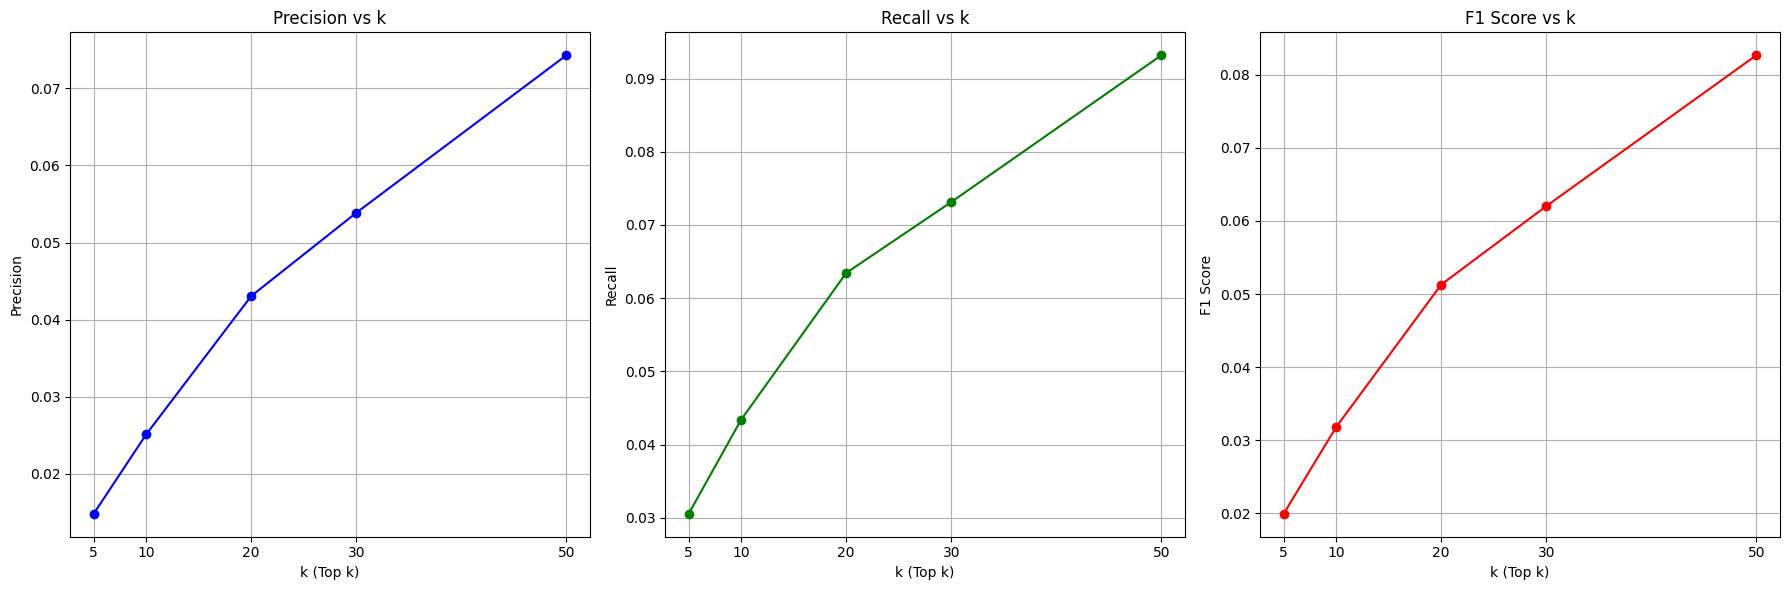

In [20]:
# Plot Precision, Recall, F1-Score for different k values
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Precision plot
axes[0].plot(list([5, 10, 20, 30, 50]), list(precision.values()), marker='o', label='Precision', color='b')
axes[0].set_title('Precision vs k')
axes[0].set_xlabel('k (Top k)')
axes[0].set_ylabel('Precision')
axes[0].set_xticks([5, 10, 20, 30, 50])
axes[0].grid(True)

# Recall plot
axes[1].plot(list([5, 10, 20, 30, 50]), list(recall.values()), marker='o', label='Recall', color='g')
axes[1].set_title('Recall vs k')
axes[1].set_xlabel('k (Top k)')
axes[1].set_ylabel('Recall')
axes[1].set_xticks([5, 10, 20, 30, 50])
axes[1].grid(True)

# F1-Score plot
axes[2].plot(list([5, 10, 20, 30, 50]), list(f1_score.values()), marker='o', label='F1 Score', color='r')
axes[2].set_title('F1 Score vs k')
axes[2].set_xlabel('k (Top k)')
axes[2].set_ylabel('F1 Score')
axes[2].set_xticks([5, 10, 20, 30, 50])
axes[2].grid(True)

plt.tight_layout()
plt.show()


In [19]:
# Testing the model
top_test_images = []
dress_test_images = []
shirt_test_images = []

image_splits_dir = "../fashionIQ_dataset/image_splits"

for filename in [f for f in os.listdir(image_splits_dir) if f.endswith('toptee.test.json')]:
    image_file = os.path.join(image_splits_dir, filename)
    with open(image_file, 'r') as f:
        top_test_images += json.load(f)
print(f"Total test images: {len(top_test_images)}")

for filename in [f for f in os.listdir(image_splits_dir) if f.endswith('dress.test.json')]:
    image_file = os.path.join(image_splits_dir, filename)
    with open(image_file, 'r') as f:
        dress_test_images += json.load(f)
print(f"Total test images: {len(dress_test_images)}")

for filename in [f for f in os.listdir(image_splits_dir) if f.endswith('shirt.test.json')]:
    image_file = os.path.join(image_splits_dir, filename)
    with open(image_file, 'r') as f:
        shirt_test_images += json.load(f)
print(f"Total test images: {len(shirt_test_images)}")

Total test images: 5374
Total test images: 3818
Total test images: 6346


Top 5 retrieved images: [('B004TJ2UR4', 5.6790771484375), ('B0051KY8IY', 6.027467250823975), ('B0051932YG', 6.087332725524902), ('B002ZLOVSO', 6.089166164398193), ('B007HZI9IQ', 6.104337692260742)]


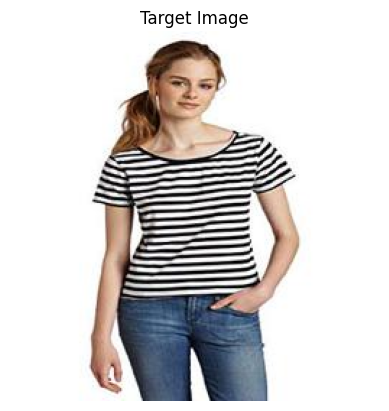

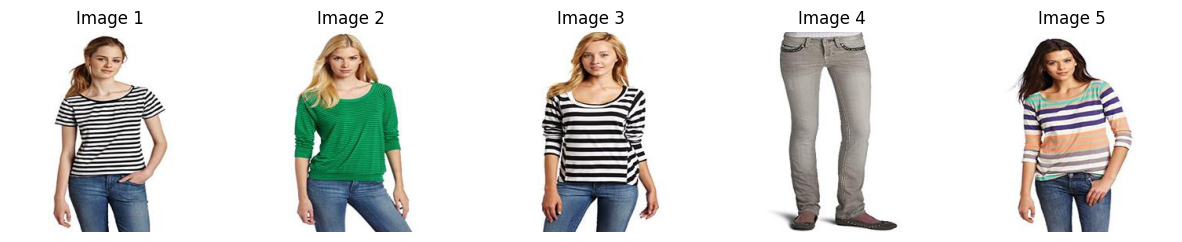

In [ ]:
query_text = "is sleeveless and has a v-neck"
query_text_emb = get_text_embedding(query_text)

# pick random image from test set
query_image = random.choice(test_images)
query_image_emb = map_image_emb[query_image]

combined_query_emb = (query_image_emb + query_text_emb) / 2.0

image_distances = []
for image in map_image_emb:
    try:
        image_emb = map_image_emb[image]
        distance = euclidean_distance(combined_query_emb, image_emb)
        image_distances.append((image, distance.item()))
    except Exception as e:
        print(f"Error processing image {image}: {e}")

image_distances.sort(key=lambda x: x[1], reverse=False)
retrieved_images = image_distances[:5]
print(f"Top 5 retrieved images: {retrieved_images}")

# Display the target image
target_image_path = os.path.join(image_dir, query_image + ".jpg")
target_image = mpimg.imread(target_image_path)
plt.imshow(target_image)
plt.axis('off')
plt.title("Target Image")
plt.show()

# Display the top 5 retrieved images
plt.figure(figsize=(15, 10))
for i, (image_id, _) in enumerate(retrieved_images):
    image_path = os.path.join(image_dir, image_id + ".jpg")
    image = mpimg.imread(image_path)
    plt.subplot(1, 5, i + 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Image {i + 1}")
plt.show()

Top 5 retrieved images: [('B007OZSW2M', 4.354318618774414), ('B005RYNXYY', 4.686582565307617), ('B008ODSK5M', 4.7470269203186035), ('B00ECF1I28', 4.764467239379883), ('B00ALSQVGI', 4.774600505828857)]


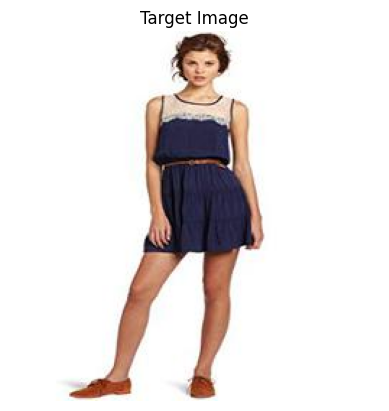

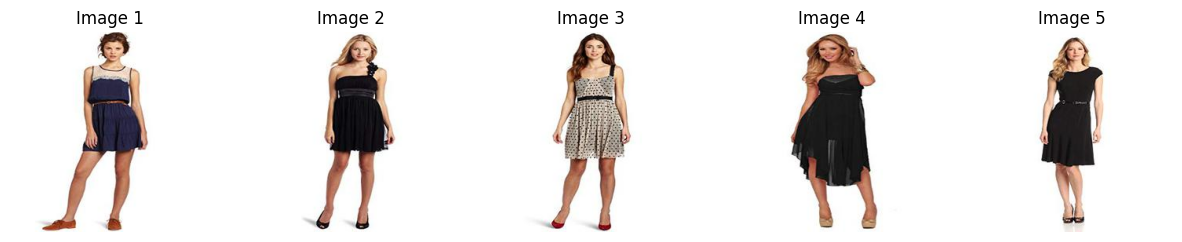

In [23]:
# test dress images
query_text = "is sleeveless black dress"
query_text_emb = get_text_embedding(query_text)

# pick random image from test set
query_image = random.choice(dress_test_images)
query_image_emb = map_image_emb[query_image]

combined_query_emb = (query_image_emb + query_text_emb) / 2.0

image_dir = "../fashionIQ_dataset/images"
image_distances = []
for image in map_image_emb:
    try:
        image_emb = map_image_emb[image]
        distance = euclidean_distance(combined_query_emb, image_emb)
        image_distances.append((image, distance.item()))
    except Exception as e:
        print(f"Error processing image {image}: {e}")

image_distances.sort(key=lambda x: x[1], reverse=False)
retrieved_images = image_distances[:5]
print(f"Top 5 retrieved images: {retrieved_images}")

# Display the target image
target_image_path = os.path.join(image_dir, query_image + ".jpg")
target_image = mpimg.imread(target_image_path)
plt.imshow(target_image)
plt.axis('off')
plt.title("Target Image")
plt.show()

# Display the top 5 retrieved images
plt.figure(figsize=(15, 10))
for i, (image_id, _) in enumerate(retrieved_images):
    image_path = os.path.join(image_dir, image_id + ".jpg")
    image = mpimg.imread(image_path)
    plt.subplot(1, 5, i + 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Image {i + 1}")
plt.show()

Top 5 retrieved images: [('B008G2KZWC', 4.739480495452881), ('B00428MI4C', 5.08171272277832), ('B008LV8U52', 5.0860090255737305), ('B005B5GEB8', 5.1147236824035645), ('B00DTOCG1K', 5.150346755981445)]


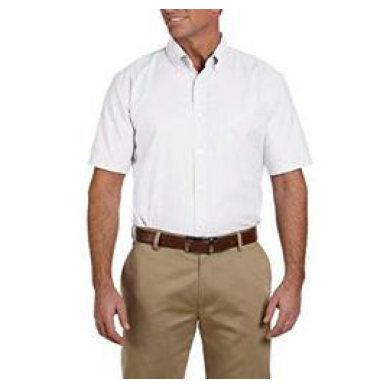

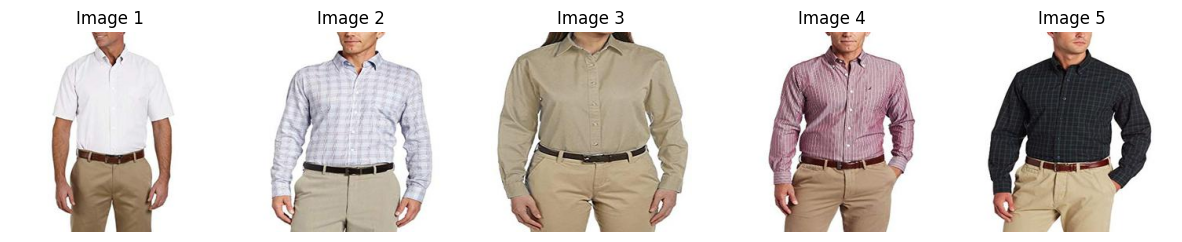

In [ ]:
# test shirt images
query_text = "is full-sleeve buttoned shirt"
query_text_emb = get_text_embedding(query_text)

# pick random image from test set
query_image = random.choice(shirt_test_images)
query_image_emb = map_image_emb[query_image]

combined_query_emb = (query_image_emb + query_text_emb) / 2.0

image_dir = "../fashionIQ_dataset/images"
image_distances = []
for image in map_image_emb:
    try:
        image_emb = map_image_emb[image]
        distance = euclidean_distance(combined_query_emb, image_emb)
        image_distances.append((image, distance.item()))
    except Exception as e:
        print(f"Error processing image {image}: {e}")

image_distances.sort(key=lambda x: x[1], reverse=False)
retrieved_images = image_distances[:5]
print(f"Top 5 retrieved images: {retrieved_images}")

# Display the target image
target_image_path = os.path.join(image_dir, query_image + ".jpg")
target_image = mpimg.imread(target_image_path)
plt.imshow(target_image)
plt.axis('off')
plt.show()

# Display the top 5 retrieved images
plt.figure(figsize=(15, 10))
for i, (image_id, _) in enumerate(retrieved_images):
    image_path = os.path.join(image_dir, image_id + ".jpg")
    image = mpimg.imread(image_path)
    plt.subplot(1, 5, i + 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Image {i + 1}")
plt.show()

Top 5 retrieved images: [('B0015N5P9W', 4.927297592163086), ('B0015N3W6U', 5.329562664031982), ('B009LCUVGQ', 5.354038715362549), ('B004Q8783Y', 5.385568141937256), ('B000RP49KK', 5.387126922607422)]


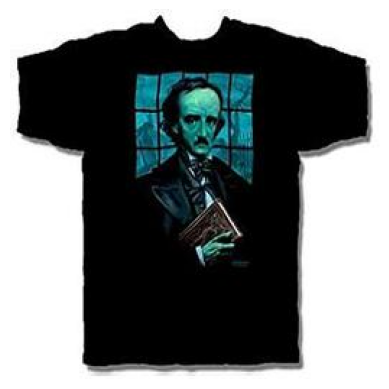

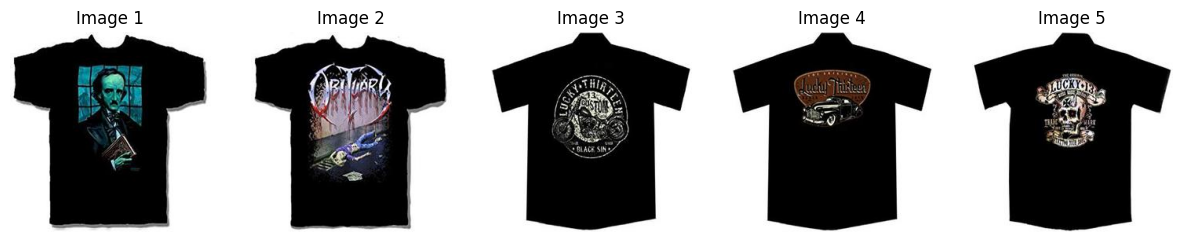

In [ ]:
# test toptee images
query_text = "black graphic tee"
query_text_emb = get_text_embedding(query_text)

# pick random image from test set
query_image = random.choice(top_test_images)
query_image_emb = map_image_emb[query_image]

combined_query_emb = (query_image_emb + query_text_emb) / 2.0

image_dir = "../fashionIQ_dataset/images"
image_distances = []
for image in map_image_emb:
    try:
        image_emb = map_image_emb[image]
        distance = euclidean_distance(combined_query_emb, image_emb)
        image_distances.append((image, distance.item()))
    except Exception as e:
        print(f"Error processing image {image}: {e}")

image_distances.sort(key=lambda x: x[1], reverse=False)
retrieved_images = image_distances[:5]
print(f"Top 5 retrieved images: {retrieved_images}")

# Display the target image
target_image_path = os.path.join(image_dir, query_image + ".jpg")
target_image = mpimg.imread(target_image_path)
plt.imshow(target_image)
plt.axis('off')
plt.show()

# Display the top 5 retrieved images
plt.figure(figsize=(15, 10))
for i, (image_id, _) in enumerate(retrieved_images):
    image_path = os.path.join(image_dir, image_id + ".jpg")
    image = mpimg.imread(image_path)
    plt.subplot(1, 5, i + 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Image {i + 1}")
plt.show()